In [ ]:
#Using different classification models on the molecular data to predict a GPCR ligand

In [319]:
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

pd.options.display.max_columns = None
import uniprot as up
import pprint
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn_pandas import DataFrameMapper
import xgboost as xgb
import imblearn.over_sampling
from sklearn.metrics import roc_curve
sns.set_style(style = 'white')



## First try KNN as a base model

In [298]:
#Read in data, need to drop a few columns
df_class = pd.read_csv('df_classification.csv')
df_class.drop(labels = ['Unnamed: 0', 'PubChem CID', 'CID'], axis = 1, inplace = True)

In [299]:
#Drop columns with NA and set features and target
df_class.dropna(inplace = True)
X = df_class.select_dtypes(include = 'number', exclude = 'object')
X.drop(['GPCR'], axis = 1, inplace = True)
y = df_class['GPCR']
X

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,MolecularWeight,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,IsotopeAtomCount,AtomStereoCount,DefinedAtomStereoCount,UndefinedAtomStereoCount,BondStereoCount,DefinedBondStereoCount,UndefinedBondStereoCount
0,336.5,5.2,336.230059,336.230059,66.8,408,0,2,4,15,24,0,1,1,0,4,4,0
5,336.5,4.1,336.230059,336.230059,77.8,421,0,3,4,14,24,0,2,2,0,4,4,0
13,752.6,5.2,752.164040,752.164040,121.0,1370,0,2,9,9,47,1,8,8,0,0,0,0
14,492.6,4.3,492.174373,492.174373,112.0,705,0,1,9,6,35,0,1,1,0,0,0,0
15,423.6,3.7,423.145048,423.145048,111.0,608,0,3,5,7,28,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15959,408.4,1.9,408.171002,408.171002,109.0,556,0,3,7,9,30,0,0,0,0,0,0,0
15960,356.4,3.1,356.063092,356.063092,67.9,567,0,0,6,3,25,0,0,0,0,0,0,0
15961,445.3,3.7,444.047747,444.047747,74.9,620,0,1,5,5,28,0,0,0,0,0,0,0
15962,383.3,2.0,383.043914,383.043914,95.8,675,0,1,8,3,26,0,3,3,0,0,0,0


In [300]:
# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [301]:
# Scale data
mapper = DataFrameMapper([(X_train.columns, StandardScaler())])
scaled_X_train = mapper.fit_transform(X_train.copy())
scaled_X_train_df = pd.DataFrame(scaled_X_train, columns=X_train.columns)
scaled_X_test = mapper.fit_transform(X_test.copy())
scaled_X_test_df = pd.DataFrame(scaled_X_test, columns=X_test.columns)

In [302]:
#Perform KNN and evaluate model on the training data
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(scaled_X_train, y_train)
y_train_pred = knn.predict(scaled_X_train)
print(accuracy_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))
print(precision_score(y_train, y_train_pred))
print(metrics.f1_score(y_train, y_train_pred))

0.8954180688584003
0.7637033625057578
0.8489503328213006
0.8040737148399613


In [303]:
#Evaluate model on the test data
knn.fit(scaled_X_test_df, y_test)
y_test_pred = knn.predict(scaled_X_test)
print(accuracy_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))
print(precision_score(y_test, y_test_pred))
print(metrics.accuracy_score(y_test, y_test_pred))
print(metrics.f1_score(y_test, y_test_pred))

0.827639751552795
0.6294326241134752
0.7411273486430062
0.827639751552795
0.6807286673058486


In [305]:
#Cross validated the KNN modles with the three types for scoring metrics
mapper = DataFrameMapper([(X.columns, StandardScaler())])
scaled_X = mapper.fit_transform(X.copy())
scaled_X_df = pd.DataFrame(scaled_X, columns=X.columns)

metrics_ = ['recall', 'precision', 'accuracy', 'f1']

for metric in metrics_:
    knn = KNeighborsClassifier(n_neighbors=5, weights = 'distance')
    scores = cross_val_score(knn, scaled_X_df, y, cv=10, scoring=metric)

    print(scores)

[0.58608059 0.55677656 0.82783883 0.72262774 0.59854015 0.70437956
 0.66058394 0.70072993 0.62637363 0.58608059]
[0.54607509 0.55677656 0.62430939 0.66666667 0.74885845 0.79752066
 0.81531532 0.74708171 0.74672489 0.59925094]
[0.74534161 0.7494824  0.81055901 0.81884058 0.82919255 0.86542443
 0.86128364 0.84782609 0.83419689 0.77202073]
[0.56537102 0.55677656 0.71181102 0.69352014 0.6653144  0.74806202
 0.72983871 0.72316384 0.6812749  0.59259259]


#### Find optimal K for each metric and each weight type and plot

In [163]:
def opt_k(X,y,metric, weight):
    mapper = DataFrameMapper([(X.columns, StandardScaler())])
    scaled_X = mapper.fit_transform(X.copy())
    scaled_X_df = pd.DataFrame(scaled_X, columns=X.columns)
    
    k_range = list(range(1, 31))
    k_scores = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, weights = weight)
        scores = cross_val_score(knn, scaled_X_df, y, cv=10, scoring= metric)
        k_scores.append(scores.mean())
        
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated ' + metric + ' with ' + weight + ' weights')

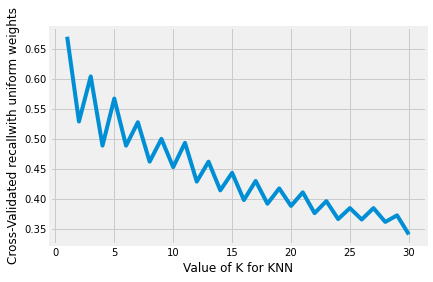

In [148]:
opt_k(X,y,'recall', 'uniform')

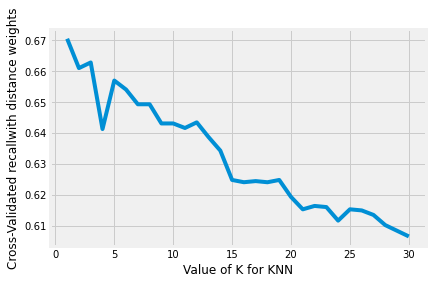

In [149]:
opt_k(X,y,'recall', 'distance')

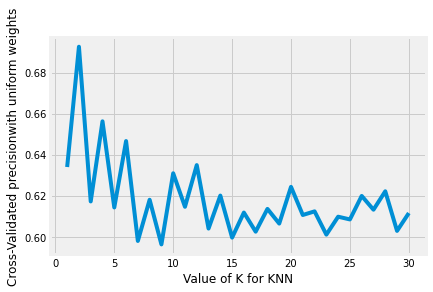

In [150]:
opt_k(X,y, 'precision', 'uniform')

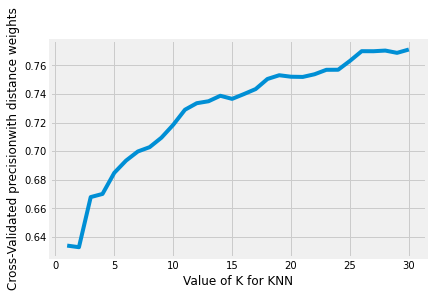

In [151]:
opt_k(X,y, 'precision', 'distance')

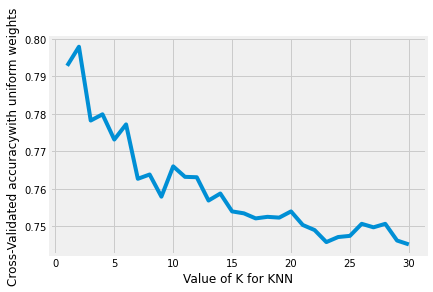

In [153]:
opt_k(X,y, 'accuracy', 'uniform')

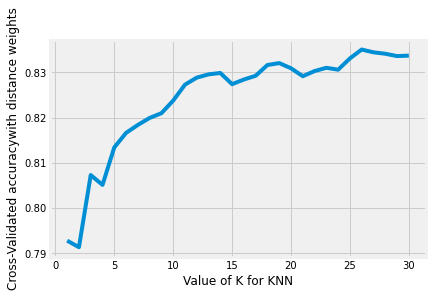

In [152]:
opt_k(X,y, 'accuracy', 'distance')

Okay, that was fun, but let's get down to business.

## Compare different models 

Now I am going to do a quick test to determine whether logreg, decision tree, random forest methods or gradient boosted trees will work best for my data

In [13]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=22)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [19]:
knn = KNeighborsClassifier(n_neighbors=5) 
print(quick_test(knn, X, y))
print(quick_test_afew_times(knn, X, y))

0.8036576949620428
0.8036576949620426


In [20]:
logreg = LogisticRegression(max_iter = 1000, C = 1000)
print(quick_test(logreg, X, y))
print(quick_test_afew_times(logreg, X, y))

0.7329192546583851
0.7329192546583851


In [43]:
decisiontree = DecisionTreeClassifier(max_depth=10)
print(quick_test(decisiontree, X, y))
print(quick_test_afew_times(decisiontree, X, y))

0.8216011042097998
0.8215665976535542


In [446]:
gbm = xgb.XGBRegressor(n_estimators = 30000)
eval_set=[(X_train,y_train),(X_test,y_test)]
print(quick_test(gbm, X, y))
print(quick_test_afew_times(gbm, X, y))

0.5995818725005724
0.5995818725005723


Ignore this - note to self
**Why don't we test/train split on the decision tree and randomforest?**
Always test/train split

Ignore this - note to self
**Is feature engineering important in decision tree and random forest?**
Always important 
But in non-linear classification models: don't worry about scaling or linearizing the data

Ignore this - note to self
**Do decision trees require scaling?**
For standard scaling - no
Hyperparameter to limit size trees - yes

Accuracy: randomforest > decisiontree > logistic regression > gbm
I'd like to look at some other metrics though, in particular f1

In [23]:
def accuracy(actuals, preds):
    return np.mean(actuals == preds)

def precision(actuals, preds):
    tp = np.sum((actuals == 1) & (preds == 1))
    fp = np.sum((actuals == 0) & (preds == 1))
    return tp / (tp + fp)

def recall(actuals, preds):
    tp = np.sum((actuals == 1) & (preds == 1))
    fn = np.sum((actuals == 1) & (preds == 0))
    return tp / (tp + fn)

def F1(actuals, preds):
    p, r = precision(actuals, preds), recall(actuals, preds)
    return 2*p*r / (p + r)

In [447]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

logreg.fit(X_train, y_train)
knn.fit(X_train, y_train)
decisiontree.fit(X_train, y_train)
randomforest.fit(X_train, y_train)
gbm.fit(X_train, y_train)

print('Logistic regression validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, logreg.predict(X_test)), 
         precision(y_test, logreg.predict(X_test)), 
         recall(y_test, logreg.predict(X_test)),
         F1(y_test, logreg.predict(X_test))))

print('\n')

print('5 nearest neighbors validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, knn.predict(X_test)), 
         precision(y_test, knn.predict(X_test)), 
         recall(y_test, knn.predict(X_test)),
         F1(y_test, knn.predict(X_test))))

print('\n')

print('Decisiontree max depth 10 validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, decisiontree.predict(X_test)), 
         precision(y_test, decisiontree.predict(X_test)), 
         recall(y_test, decisiontree.predict(X_test)),
         F1(y_test, decisiontree.predict(X_test))))

print('\n')

print('Random Forest max depth 10 validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, randomforest.predict(X_test)), 
         precision(y_test, randomforest.predict(X_test)), 
         recall(y_test, randomforest.predict(X_test)),
         F1(y_test, randomforest.predict(X_test))))

print('\n')

print('Gradient boosted trees metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, gbm.predict(X_test)), 
         precision(y_test, gbm.predict(X_test)), 
         recall(y_test, gbm.predict(X_test)),
         F1(y_test, gbm.predict(X_test))))

Logistic regression validation metrics: 
 Accuracy: 0.7262 
 Precision: 0.5870 
 Recall: 0.1465 
 F1: 0.2344


5 nearest neighbors validation metrics: 
 Accuracy: 0.8799 
 Precision: 0.8393 
 Recall: 0.7179 
 F1: 0.7739


Decisiontree max depth 10 validation metrics: 
 Accuracy: 0.8199 
 Precision: 0.7662 
 Recall: 0.5335 
 F1: 0.6290


Random Forest max depth 10 validation metrics: 
 Accuracy: 0.9006 
 Precision: 0.8737 
 Recall: 0.7631 
 F1: 0.8147


Gradient boosted trees metrics: 
 Accuracy: 0.0005 
 Precision: 1.0000 
 Recall: 1.0000 
 F1: 1.0000


**How would I increase recall in my best method?**
1) Model selection - random forest seems to work best
2) Feature engineering - I put my logic below
3) Handle class imbalance -
4) Hyperparameter tuning
5) Threshold selection

## Data resampling
Correct for class imbalances between GPCRs and not GPCRs. 

In [74]:
# Determine if there is class imbalances 
print(df_class.GPCR.sum())
print(len(df_class.GPCR))

2735
9658


In [77]:
#Compare strateiges - RandomOverSampler and SMOTE

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_OS, y_train_OS = ROS.fit_resample(X_train, y_train)
rf_OS = RandomForestClassifier(n_estimators=100)
rf_OS.fit(X_train_OS, y_train_OS)

print('Random Forest with over sampling : \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, rf_OS.predict(X_test)), 
         precision(y_test, rf_OS.predict(X_test)), 
         recall(y_test, rf_OS.predict(X_test)),
         F1(y_test, rf_OS.predict(X_test))))


smote = imblearn.over_sampling.SMOTE(sampling_strategy = ratio, random_state=42) 

X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)
rf_SMOTE = RandomForestClassifier(n_estimators=100)
rf_SMOTE.fit(X_train_SMOTE, y_train_SMOTE)

print('Random Forest with over sampling : \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test, rf_SMOTE.predict(X_test)), 
         precision(y_test, rf_SMOTE.predict(X_test)), 
         recall(y_test, rf_SMOTE.predict(X_test)),
         F1(y_test, rf_SMOTE.predict(X_test))))


/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (8684) in class 1 will be larger than the number of samples in the majority class (class #0 -> 5555)
  warnings.warn(


Random Forest with over sampling : 
 Accuracy: 0.9006 
 Precision: 0.8321 
 Recall: 0.8262 
 F1: 0.8292


/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/imblearn/utils/_validation.py:318: UserWarning: After over-sampling, the number of samples (8684) in class 1 will be larger than the number of samples in the majority class (class #0 -> 5555)
  warnings.warn(


Random Forest with over sampling : 
 Accuracy: 0.8898 
 Precision: 0.7844 
 Recall: 0.8582 
 F1: 0.8196


## Feature Engineering
### Very general characteristics of GPCR ligands 
- Binds in a more hydrophobic environment (so tends to have lower octanol/water partition coefficient which is XlogP), and a lower polar surface area
- H-bonds donors and acceptors are very important in binding
- Heavy atom count will skew higher due to peptide ligands

In [247]:
# Normalize for molecular mass
df_class_fe = df_class.copy()

df_class_fe['TPSA_Mass'] = df_class['TPSA']/df_class['ExactMass']
df_class_fe['XLogP_Mass'] = df_class['XLogP']/df_class['ExactMass']
df_class_fe['HBondAcceptorCount_Mass'] = df_class['HBondAcceptorCount']/df_class['ExactMass']
df_class_fe['HBondDonorCount_Mass'] = df_class['HBondDonorCount']/df_class['ExactMass']
df_class_fe['HeavyAtomCount_Mass'] = df_class['HeavyAtomCount']/df_class['ExactMass']
df_class_fe['Complexity_Mass'] = df_class['Complexity']/df_class['ExactMass']
# len(df_class_fe.GPCR

In [257]:
X_fe = df_class_fe.select_dtypes(include = 'number', exclude = 'object')
X_fe.drop(['GPCR'], axis = 1, inplace = True)
y_fe = df_class_fe['GPCR']
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, y_fe, test_size=0.2, random_state=22)
# y_train_fe

y_train_fe.value_counts()

0    5544
1    2182
Name: GPCR, dtype: int64

In [381]:
n_pos = np.sum(y_train_fe == 1)
n_neg = np.sum(y_train_fe == 0)
ratio = {1 : int(n_pos * 2), 0 : n_neg} 
ratio

{1: 4364, 0: 5544}

In [449]:
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=22) 
X_train_OS_fe, y_train_OS_fe = ROS.fit_sample(X_train_fe, y_train_fe) 
rf_OS_fe = RandomForestClassifier(n_estimators=100)
rf_OS_fe.fit(X_train_OS_fe, y_train_OS_fe)

y_train_OS_fe.value_counts()

0    5544
1    4364
Name: GPCR, dtype: int64

In [450]:
print('Feature engineering improvements: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_test_fe, rf_OS_fe.predict(X_test_fe)), 
         precision(y_test_fe, rf_OS_fe.predict(X_test_fe)), 
         recall(y_test_fe, rf_OS_fe.predict(X_test_fe)),
         F1(y_test_fe, rf_OS_fe.predict(X_test_fe))))

Feature engineering improvements: 
 Accuracy: 0.9084 
 Precision: 0.8701 
 Recall: 0.7993 
 F1: 0.8332


## Parameter tuning
First I need to figure out if I am overfitting or underfitting

In [451]:
print('Train data metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy(y_train_OS_fe, rf_OS_fe.predict(X_train_OS_fe)), 
         precision(y_train_OS_fe, rf_OS_fe.predict(X_train_OS_fe)), 
         recall(y_train_OS_fe, rf_OS_fe.predict(X_train_OS_fe)),
         F1(y_train_OS_fe, rf_OS_fe.predict(X_train_OS_fe))))

Train data metrics: 
 Accuracy: 0.9919 
 Precision: 0.9859 
 Recall: 0.9959 
 F1: 0.9909


I am definitely overfitting. Increase n_estimators above from 100 to 500. 

Previous metrics - 
 Accuracy: 0.9099 
 Precision: 0.8708 
 Recall: 0.8047 
 F1: 0.8365
New metrics - 
 Accuracy: 0.9110 
 Precision: 0.8757 
 Recall: 0.8029 
 F1: 0.8377
 
That didn't do much

Try modifying hyperparameters of the random forest model

In [452]:
y_test_fe# cross_val_score(rf_OS_fe_depth, X_test_fe, y_test_fe, cv=5, scoring= 'f1')

11473    0
11786    0
3019     1
11578    0
11352    0
        ..
8674     1
6732     0
13203    0
1675     0
15360    0
Name: GPCR, Length: 1932, dtype: int64

Text(0.5, 0, 'Max Depth for Random Forest')

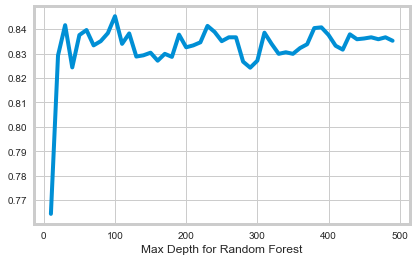

In [435]:
# Change max_depth, didn't do much

depth_range = np.arange(10, 500, 10)
depth_scores = []
for depth in depth_range:
    rf_OS_fe_depth = RandomForestClassifier(n_estimators = 100, max_depth = depth)
    rf_OS_fe_depth.fit(X_train_OS_fe, y_train_OS_fe)
    y_test_pred_rf = rf_OS_fe_depth.predict(X_test_fe)
    scores = metrics.f1_score(y_test_fe, y_test_pred_rf)
    depth_scores.append(scores.mean())
    
plt.plot(depth_range, depth_scores)
plt.xlabel('Max Depth for Random Forest')

Text(0.5, 0, 'Max Depth for Random Forest')

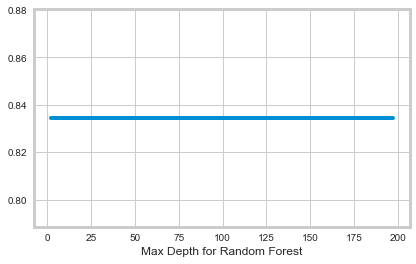

In [432]:
nodes_range = np.arange(2, 200, 5)
nodes_scores = []
for nodes in nodes_range:
    rf_OS_fe_nodes = RandomForestClassifier(n_estimators = 100, max_leaf_nodes = nodes)
    rf_OS_fe_nodes.fit(X_train_OS_fe, y_train_OS_fe)
    y_test_pred_rf = rf_OS_fe_depth.predict(X_test_fe)
    scores = metrics.f1_score(y_test_fe, y_test_pred_rf)
    nodes_scores.append(scores.mean())
    
plt.plot(nodes_range, nodes_scores)
plt.xlabel('Nodes ranbe for Random Forest')

Text(0.5, 0, 'Max Depth for Random Forest')

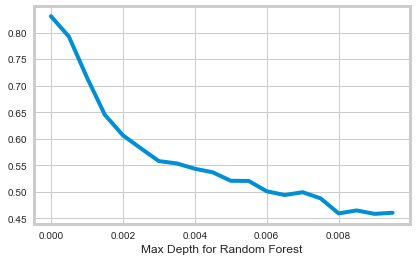

In [439]:
#Next I'll try the ccp score
ccp_range = np.arange(0, 0.01, .0005)
ccp_scores = []
for ccp in ccp_range:
    rf_OS_fe_ccp = RandomForestClassifier(n_estimators = 100, ccp_alpha = ccp)
    rf_OS_fe_ccp.fit(X_train_OS_fe, y_train_OS_fe)
    y_test_pred_rf = rf_OS_fe_ccp.predict(X_test_fe)
    scores = metrics.f1_score(y_test_fe, y_test_pred_rf)
    ccp_scores.append(scores.mean())
    
plt.plot(ccp_range, ccp_scores)
plt.xlabel('CCP for Random Forest')

Text(0.5, 0, 'Max Depth for Random Forest')

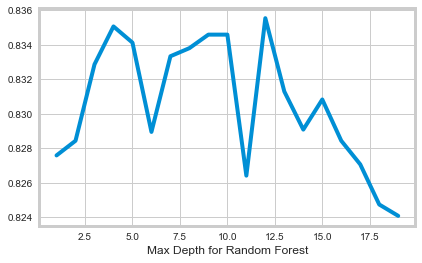

In [443]:
#Now try number of features
feat_range = np.arange(1, 20, 1)
feat_scores = []
for feat in feat_range:
    rf_OS_fe_feat = RandomForestClassifier(n_estimators = 100, max_features = feat)
    rf_OS_fe_feat.fit(X_train_OS_fe, y_train_OS_fe)
    y_test_pred_rf = rf_OS_fe_feat.predict(X_test_fe)
    scores = metrics.f1_score(y_test_fe, y_test_pred_rf)
    feat_scores.append(scores.mean())
    
plt.plot(feat_range, feat_scores)
plt.xlabel('Feature Range for Random Forest')

Text(0.5, 0, 'Minimun leaf size for Random Forest')

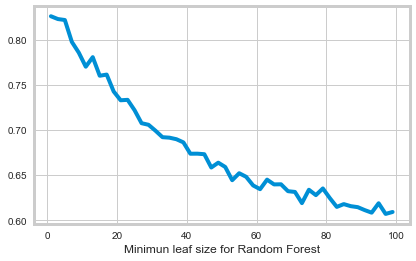

In [445]:
#Finally try leaf_range
leaf_range = np.arange(1, 100, 2)
leaf_scores = []
for leaf in leaf_range:
    rf_OS_fe_leaf = RandomForestClassifier(n_estimators = 100, min_samples_leaf = leaf)
    rf_OS_fe_leaf.fit(X_train_OS_fe, y_train_OS_fe)
    y_test_pred_rf = rf_OS_fe_leaf.predict(X_test_fe)
    scores = metrics.f1_score(y_test_fe, y_test_pred_rf)
    leaf_scores.append(scores.mean())
    
plt.plot(leaf_range, leaf_scores)
plt.xlabel('Minimun leaf size for Random Forest')

Tuning of the parameters above didn't really help the overfitting problem - I probably just need more data

## Cross validation and graphing of metrics

In [367]:
#Cross-validation of model
scores = cross_val_score(rf_OS_fe, X_fe, y_fe, cv=10, scoring='f1')
print(scores)
print(scores.mean())
print(scores.std())
#Why is this so much lower??

[0.5862069  0.52272727 0.72964169 0.74898785 0.67276888 0.70711297
 0.80869565 0.73833671 0.72340426 0.57317073]
0.681105291996724
0.08648284767555002


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_facecolor'

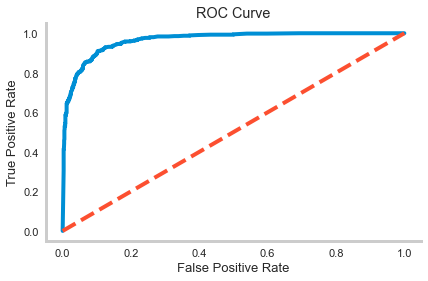

In [332]:
#ROC
sns.set_style(style = 'whitegrid')
fpr, tpr, _ = roc_curve(y_test_fe, rf_OS_fe.predict_proba(X_test_fe)[:,1])
plt.plot(fpr, tpr)

# fpr, tpr, _ = roc_curve(y_test, rf_OS.predict_proba(X_test)[:,1])
# sns.lineplot(fpr, tpr)
x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')
plt.title('ROC Curve')
plt.xticks(size = 11)
plt.yticks(size = 11)
plt.xlabel('False Positive Rate', size = 13)
plt.ylabel('True Positive Rate', size = 13)
plt.grid(False)
sns.despine()
plt.savefig('ROC.svg', bbox_inches = 'tight'); 

AttributeError: module 'matplotlib.pyplot' has no attribute 'patch'

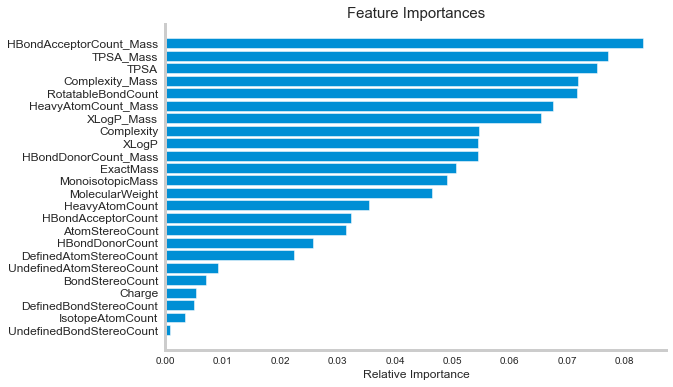

In [458]:
# Feature importance
# plt.fig_size([10,10])
sns.set_style(style = 'whitegrid')
features = X_fe.columns
importances = rf_OS_fe.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (8, 6), facecolor = 'w')

plt.title('Feature Importances', size = 15)
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices], size = 12)
plt.xlabel('Relative Importance', size = 12)
plt.grid(False)
sns.despine()
plt.patch.set_facecolor('white')
plt.savefig('feature_importance.svg', bbox_inches = 'tight')

In [339]:
X_test_fe.shape
y_test_fe.shape

(1932,)

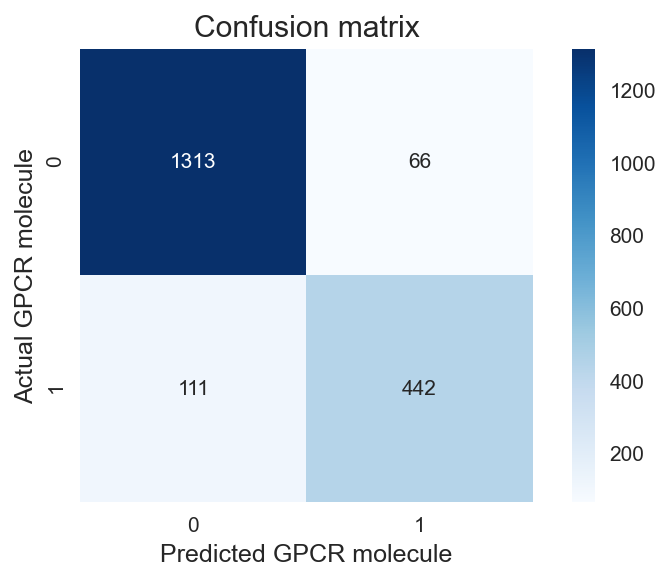

In [455]:
#Confusion matrix
rf_OS_fe_confusion = confusion_matrix(y_test_fe, rf_OS_fe.predict(X_test_fe))
plt.figure(dpi=150)
sns.heatmap(rf_OS_fe_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt = 'g')
plt.xlabel('Predicted GPCR molecule')
plt.ylabel('Actual GPCR molecule')
plt.title('Confusion matrix')
plt.savefig('confusion_matrix.svg', facecolor = 'red')

**Can I determine which samples are being misclassified?**

In [359]:

def make_confusion_matrix(model, threshold=0.16):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict_fe = (model.predict_proba(X_test_fe)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test_fe, y_predict_fe)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['legit', 'fraud'],
           yticklabels=['legit', 'fraud']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.savefig('confusion_matrix_threshold.svg')

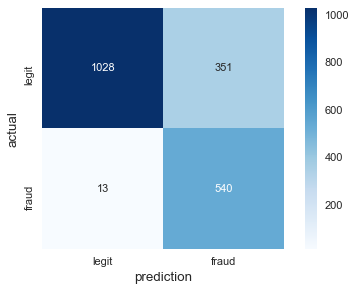

In [360]:
make_confusion_matrix(rf_OS_fe, 0.16)

In [355]:
#Interactive confusion matrix 
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(rf_OS_fe, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…